In [ ]:
import os
import glob
from collections import Counter
import matplotlib.pyplot as plt
import yaml, json, os, random, cv2, glob
import numpy as np
from pathlib import Path
import pandas as pd

In [31]:
DATASET_ROOT = '/kaggle/input/pill-seg'

all_classes = set()
class_counts = Counter()

for split in ['train', 'valid', 'test']:
    label_dir = os.path.join(DATASET_ROOT, split, 'labels')
    label_files = glob.glob(os.path.join(label_dir, '*.txt'))

    for file_path in label_files:
        with open(file_path, 'r') as f:
            for line in f:
                line = line.strip()
                if line:  # skip empty lines
                    parts = line.split()
                    cls_id = int(parts[0])
                    all_classes.add(cls_id)
                    class_counts[cls_id] += 1  # count occurrences per class

print(f"Total unique classes (this is your nc): {len(all_classes)}")
print(f"Class IDs found: {sorted(all_classes)}")
print(f"Min class ID: {min(all_classes) if all_classes else 'None'}")
print(f"Max class ID: {max(all_classes) if all_classes else 'None'}")
print("\nTop 10 most frequent classes:")
for cls_id, count in class_counts.most_common(10):
    print(f"  Class {cls_id}: {count} instances")
# Generate placeholder names for all 180 classes
num_classes = 180
CLASS_NAMES = [f'class_{i}' for i in range(num_classes)]
print(f"\nGenerated {len(CLASS_NAMES)} placeholder class names.")


Total unique classes (this is your nc): 180
Class IDs found: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179]
Min class ID: 0
Max class ID: 179

Top 10 most frequent classes:
  Class 177: 5766 instances
  Class 178: 2390 instances
  Class 27: 254 instances
 

In [32]:
!pip install ultralytics --no-deps

In [33]:
DATASET_ROOT = '/kaggle/input/pill-seg'
IMAGES_TRAIN = os.path.join(DATASET_ROOT, 'train', 'images')
IMAGES_VAL = os.path.join(DATASET_ROOT, 'valid', 'images')   # Note: valid folder
IMAGES_TEST = os.path.join(DATASET_ROOT, 'test', 'images')
LABELS_TRAIN = os.path.join(DATASET_ROOT, 'train', 'labels')
LABELS_VAL = os.path.join(DATASET_ROOT, 'valid', 'labels')   # Note: valid folder
LABELS_TEST = os.path.join(DATASET_ROOT, 'test', 'labels')
def validate_images(img_dir, label_dir, max_check=100):
    """Check for corrupted images and remove them with their labels."""
    img_files = glob.glob(os.path.join(img_dir, "*.*"))
    img_files = [f for f in img_files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    corrupted = []
    print(f"Checking {min(max_check, len(img_files))} images in {img_dir}...")
    for i, img_path in enumerate(img_files[:max_check]):
        try:
            img = cv2.imread(img_path)
            if img is None:
                corrupted.append(img_path)
                print(f"Corrupted: {os.path.basename(img_path)}")
        except Exception as e:
            corrupted.append(img_path)
            print(f"Error reading {os.path.basename(img_path)}: {e}")
    print(f"Found {len(corrupted)} corrupted images out of {min(max_check, len(img_files))} checked")
    return corrupted

print("=" * 60)
print("VALIDATING DATASET")
print("=" * 60)
corrupted_train = validate_images(IMAGES_TRAIN, LABELS_TRAIN, max_check=100)
corrupted_val = validate_images(IMAGES_VAL, LABELS_VAL, max_check=50)


VALIDATING DATASET
Checking 100 images in /kaggle/input/pill-seg/train/images...
Found 0 corrupted images out of 100 checked
Checking 50 images in /kaggle/input/pill-seg/valid/images...
Found 0 corrupted images out of 50 checked


In [34]:
yaml_path = '/kaggle/working/data.yaml'

# Correct YAML with matching nc and names length
DATA_YAML = {
    'path': DATASET_ROOT,          # root directory
    'train': 'train/images',       # relative to path
    'val': 'valid/images',         # must be 'val'
    'test': 'test/images',         # optional
    'nc': num_classes,
    'names': CLASS_NAMES
}

with open(yaml_path, 'w') as f:
    yaml.dump(DATA_YAML, f)

print("\n" + "=" * 60)
print("DATA CONFIGURATION")
print("=" * 60)
print(f"YAML path: {yaml_path}")
print(f"Train images exist: {os.path.exists(IMAGES_TRAIN)}")
print(f"Val images exist: {os.path.exists(IMAGES_VAL)}")
print(f"Test images exist: {os.path.exists(IMAGES_TEST)}")


DATA CONFIGURATION
YAML path: /kaggle/working/data.yaml
Train images exist: True
Val images exist: True
Test images exist: True


In [35]:
from ultralytics import YOLO

print("\n" + "=" * 60)
print("STARTING TRAINING")
print("=" * 60)

try:
    model = YOLO('yolo11n-seg.pt')
    results = model.train(
        data=yaml_path,
        epochs=60,
        imgsz=640,
        batch=8,
        workers=2,
        device=0,
        patience=10,
        save=True,
        save_period=-1,
        pretrained=True,
        optimizer="auto",
        project="/kaggle/working/yolo11_runs",
        name="detect_yolo11_seg",
        exist_ok=True,
        amp=True
    )
    print("\nTraining completed successfully!")
    print(f"Results saved to: {results.save_dir}")
except FileNotFoundError:
    print("Model weights 'yolo11n-seg.pt' not found! Please verify the file name or download it first.")
except Exception as e:
    print(f"\nTraining failed with error:")
    print(f"{type(e).__name__}: {e}")
    raise


STARTING TRAINING
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=detect_yolo11_seg, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspecti

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        598       3810      0.348      0.323      0.234      0.231      0.348      0.323      0.234      0.223
               class_1          2         13          1          0     0.0101     0.0101          1          0     0.0101     0.0101
               class_2          2         15      0.293      0.333      0.345      0.332      0.293      0.333      0.345      0.335
               class_4          2         22          1          0      0.134      0.134          1          0      0.134      0.134
               class_5          2         21      0.432      0.795      0.416      0.385      0.432      0.795      0.416      0.387
               class_6          1         11          0          0      0.115      0.115          0          0      0.115      0.114
               class_7          1         15     0.0707     0.0667     0.0876     0.0861     0.0707     0.0667     0.0876      0.085
               class_8          1          8     0.0723      0.263   

In [36]:

print("\n" + "=" * 60)
print("VALIDATION METRICS")
print("=" * 60)

run_dir = results.save_dir if 'results' in locals() and hasattr(results, "save_dir") else "/kaggle/working/yolo11_runs/detect_yolo11_seg"
best_ckpt = os.path.join(run_dir, "weights", "best.pt")

if os.path.exists(best_ckpt):
    print(f"Loading best weights: {best_ckpt}")
    model = YOLO(best_ckpt)

    val_metrics = model.val(split="val")

    print(f"\nValidation Results:")
    print(f"  Box mAP50-95: {val_metrics.box.map:.4f}")
    print(f"  Box mAP50: {val_metrics.box.map50:.4f}")
    print(f"  Mask mAP50-95: {val_metrics.seg.map:.4f}")
    print(f"  Mask mAP50: {val_metrics.seg.map50:.4f}")
else:
    print("Best checkpoint not found!")


print("\nAll done!")



VALIDATION METRICS
Loading best weights: /kaggle/working/yolo11_runs/detect_yolo11_seg/weights/best.pt
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-seg summary (fused): 113 layers, 2,924,244 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 242.0±262.5 MB/s, size: 128.0 KB)
val: Scanning /kaggle/input/pill-seg/valid/labels... 598 images, 6 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 598/598 685.2it/s 0.9s0.1s
WARNING ⚠️ val: Cache directory /kaggle/input/pill-seg/valid is not writable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 38/38 3.3it/s 11.7s0.2s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        598       3810      0.367      0.308      0.234      0.232      0.367      0.308      0.234      0.223
               class_1          2         13          1          0     0.0101     0.0101          1          0     0.0101     0.0101
               class_2          2         15      0.296      0.267      0.356      0.348      0.296      0.267      0.356      0.345
               class_4          2         22          1          0      0.134      0.134          1          0      0.134      0.134
               class_5          2         21      0.436      0.737      0.415      0.388      0.436      0.737      0.415      0.385
               class_6          1         11          0          0      0.116      0.113          0          0      0.116      0.114
               class_7          1         15     0.0923     0.0667     0.0888     0.0888     0.0923     0.0667     0.0888      0.086
               class_8          1          8     0.0714       0.25   

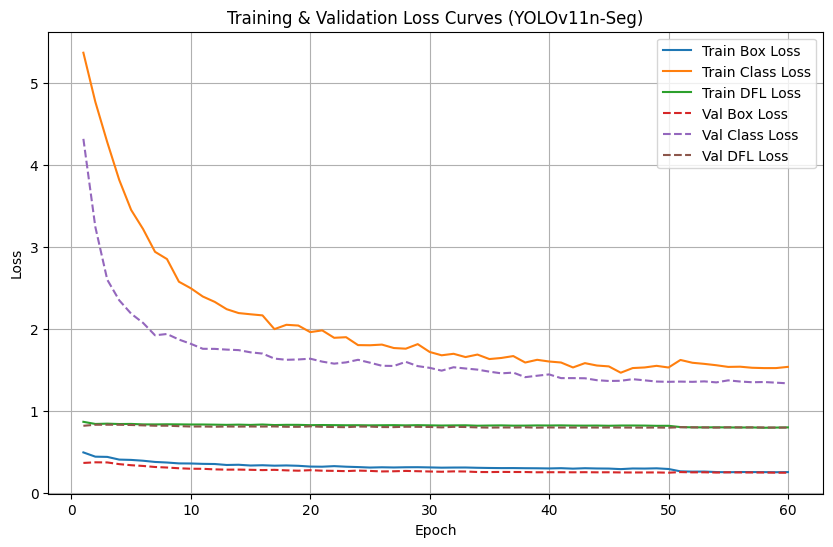

In [37]:
import os
import pandas as pd
import matplotlib.pyplot as plt


results_dir = '/kaggle/working/yolo11_runs/detect_yolo11_seg'

results_csv = os.path.join(results_dir, "results.csv")
results = pd.read_csv(results_csv)

# Plot key losses
plt.figure(figsize=(10, 6))
plt.plot(results["epoch"], results["train/box_loss"], label="Train Box Loss")
plt.plot(results["epoch"], results["train/cls_loss"], label="Train Class Loss")
plt.plot(results["epoch"], results["train/dfl_loss"], label="Train DFL Loss")
plt.plot(results["epoch"], results["val/box_loss"], '--', label="Val Box Loss")
plt.plot(results["epoch"], results["val/cls_loss"], '--', label="Val Class Loss")
plt.plot(results["epoch"], results["val/dfl_loss"], '--', label="Val DFL Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Curves (YOLOv11n-Seg)")
plt.legend()
plt.grid(True)
plt.show()


In [38]:
import os
import glob
import random
from ultralytics import YOLO

print("\n" + "=" * 60)
print("TEST INFERENCE")
print("=" * 60)

# Ensure DATASET_ROOT is defined before this (e.g., DATASET_ROOT = '/kaggle/input/your-dataset-folder')
test_img_dir = os.path.join(DATASET_ROOT, 'test', 'images')
test_imgs = glob.glob(os.path.join(test_img_dir, '*.*'))
test_imgs = [f for f in test_imgs if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

if len(test_imgs) > 0:
    sample_imgs = random.sample(test_imgs, min(6, len(test_imgs)))
    
    print(f"Running inference on {len(sample_imgs)} test images...")
    predictions = model.predict(
        source=sample_imgs,
        imgsz=640,
        conf=0.25,
        verbose=False,
        save=False
    )
    print("\n Inference completed successfully!")
else:
    print(" No test images found in the specified directory.")



TEST INFERENCE
Running inference on 6 test images...

 Inference completed successfully!


In [39]:
def draw_gt_polygons(img_path, label_path, class_names):
    """Draw ground truth segmentation polygons."""
    img = cv2.imread(img_path)
    if img is None:
        return None
    
    h, w = img.shape[:2]
    overlay = img.copy()

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                vals = list(map(float, line.strip().split()))
                cls_id = int(vals[0])
                coords = vals[1:]
                
                if len(coords) > 4:
                    pts = np.array(coords).reshape(-1, 2)
                    pts[:, 0] *= w
                    pts[:, 1] *= h
                    pts = pts.astype(np.int32)
                    
                    color = (0, 255, 0)  # Green for GT
                    cv2.fillPoly(overlay, [pts], color)
                    cv2.polylines(overlay, [pts], True, (255, 255, 255), 2)
                    
                    label = class_names[cls_id] if cls_id < len(class_names) else str(cls_id)
                    cv2.putText(overlay, f"GT: {label}", (pts[0][0], pts[0][1] - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    
    return cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

def draw_pred_polygons(result):
    """Draw predicted segmentation polygons."""
    img = result.orig_img.copy()

    if hasattr(result, 'masks') and result.masks is not None:
        for i, seg in enumerate(result.masks.xy):
            poly = np.array(seg, dtype=np.int32)
            color = (0, 0, 255)  # Red for predictions
            cv2.fillPoly(img, [poly], color)
            cv2.polylines(img, [poly], True, (255, 255, 255), 2)
            
            if hasattr(result, 'boxes') and result.boxes.cls is not None:
                cls_id = int(result.boxes.cls[i].item())
                conf = float(result.boxes.conf[i].item())
                label = result.names.get(cls_id, str(cls_id))
                x, y = poly[0]
                cv2.putText(img, f"{label} {conf:.2f}", (int(x), int(y) - 6),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


PREDICTION AND VISUALIZATION
Running inference on 4 test images...


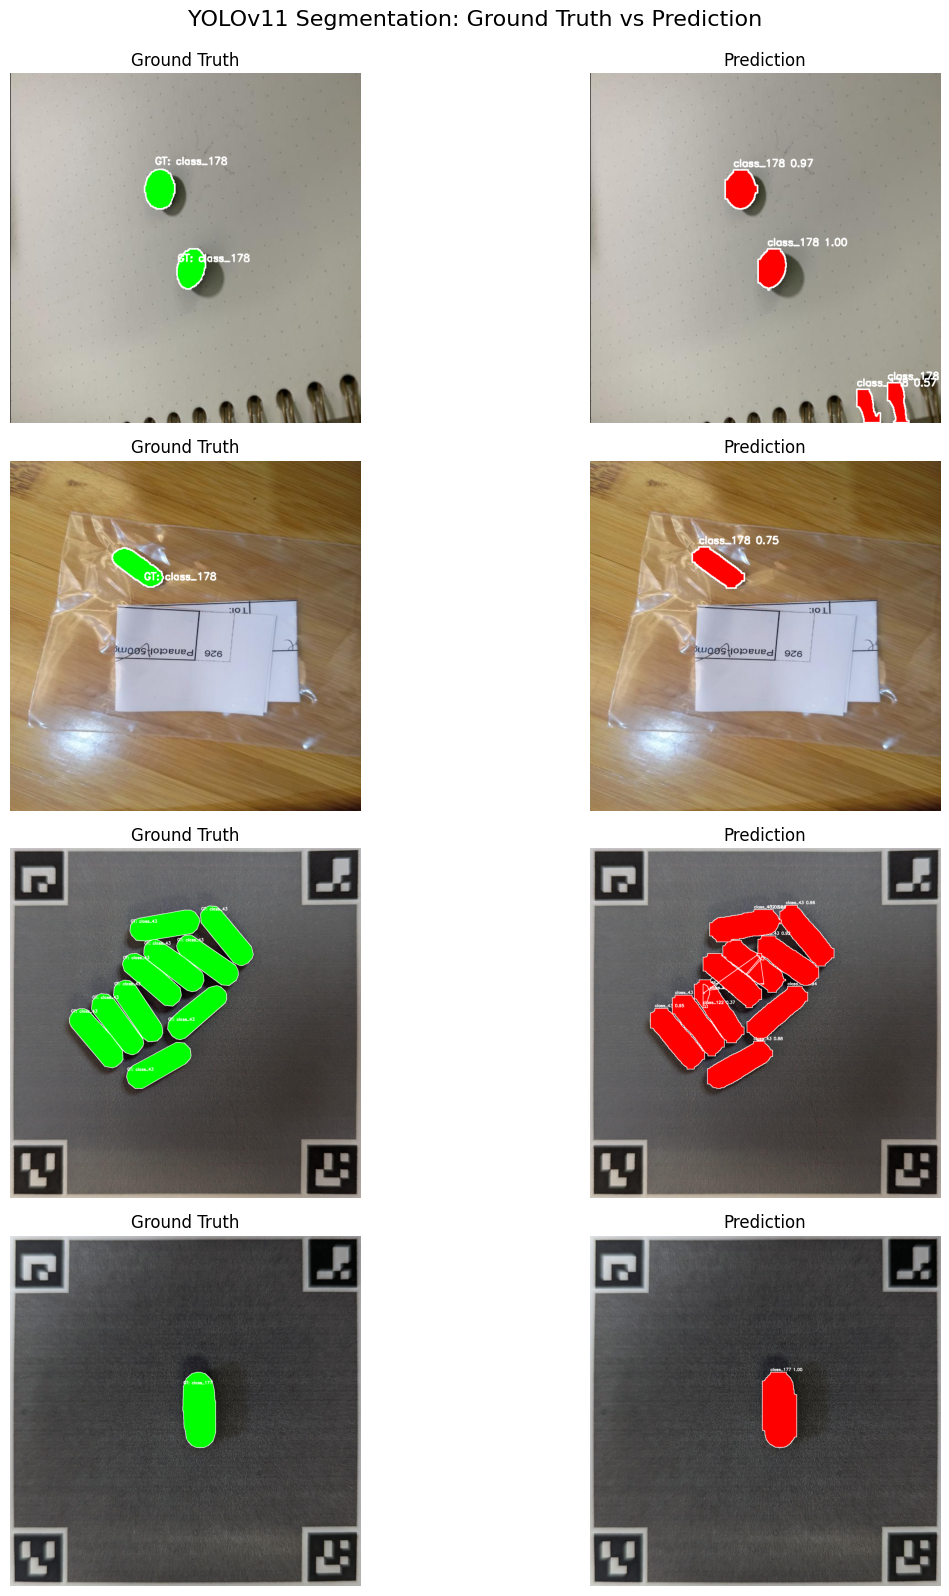


All done!


In [40]:
print("\n" + "=" * 60)
print("PREDICTION AND VISUALIZATION")
print("=" * 60)

test_imgs = glob.glob(os.path.join(IMAGES_TEST, "*.*"))
test_imgs = [f for f in test_imgs if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
sample_imgs = random.sample(test_imgs, min(4, len(test_imgs)))

print(f"Running inference on {len(sample_imgs)} test images...")
preds = model.predict(source=sample_imgs, imgsz=640, conf=0.25, save=False, verbose=False)

fig, axes = plt.subplots(len(preds), 2, figsize=(14, 4 * len(preds)))
if len(preds) == 1:
    axes = axes.reshape(1, -1)

for i, result in enumerate(preds):
    img_path = result.path
    label_path = os.path.join(LABELS_TEST, 
                              os.path.basename(img_path).rsplit('.', 1)[0] + '.txt')
    
    vis_gt = draw_gt_polygons(img_path, label_path, CLASS_NAMES)
    vis_pred = draw_pred_polygons(result)
    
    axes[i, 0].imshow(vis_gt)
    axes[i, 0].set_title("Ground Truth", fontsize=12)
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(vis_pred)
    axes[i, 1].set_title("Prediction", fontsize=12)
    axes[i, 1].axis('off')

# ✅ Updated title for YOLOv11
plt.suptitle("YOLOv11 Segmentation: Ground Truth vs Prediction", fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

print("\nAll done!")
